# Phase 2: Advanced Environmental Data Intelligence & Pattern Analysis


In [26]:
# Imports and setup
import os, io, textwrap
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy import stats
import missingno as msno
from scipy.stats import pearsonr
from IPython.display import Markdown
from pathlib import Path

In [2]:
# Output dirs
charts_dir = Path("/mnt/data/air_quality_charts")
charts_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Matplotlib style settings
mpl.rcParams.update({
    "figure.figsize": (10, 4),
    "figure.dpi": 140,
    "axes.titlesize": "large",
    "axes.labelsize": "medium",
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
    "axes.grid": True,
    "grid.alpha": 0.25,
    "legend.frameon": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# Date/time formatter
def _format_time_axis(ax):
    loc = AutoDateLocator()
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(loc))

SAVE_FIGS = False
FIG_DIR = charts_dir
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Standardized figure handling
def show_fig(fig, name: str | None = None):
    fig.tight_layout()
    display(fig)
    if SAVE_FIGS and name:
        fig.savefig(FIG_DIR / name, dpi=200, bbox_inches="tight")
    plt.close(fig)


## 1. Load & Clean

In [5]:
data_path = Path("AirQualityUCI.csv")

df_raw = pd.read_csv(
    data_path,
    sep=";",
    decimal=",",
    dtype={"Date": str, "Time": str},
    engine="python",  # a bit more forgiving for odd separators
)
df_raw

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Drop empty/unnamed trailing columns (the file has two trailing ';')
mask = (~df_raw.columns.str.startswith("Unnamed")) & (df_raw.columns.str.strip() != "")
df_raw = df_raw.loc[:, mask].copy()

# Normalize column names
df_raw.columns = df_raw.columns.str.strip()

# Replace sentinel -200 with NaN
df = df_raw.replace(-200, np.nan).copy()

# Compose timestamp and index
dt = pd.to_datetime(
    df["Date"].str.strip() + " " + df["Time"].str.strip(),
    format="%d/%m/%Y %H.%M.%S",
    errors="coerce",
)

# Keep only valid timestamps
df = df[dt.notna()].copy()
df["timestamp"] = dt[dt.notna()].values
df = df.set_index("timestamp").sort_index()

# Convert all non-Date/Time columns to numeric
for c in df.columns:
    if c not in ("Date", "Time"):
        df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.asfreq("H")

# Rename pollutants to readable names
rename_map = {
    "CO(GT)": "CO_mg_m3",
    "NOx(GT)": "NOx_ppb",
    "C6H6(GT)": "Benzene_ug_m3",
}
present_map = {k: v for k, v in rename_map.items() if k in df.columns}
df = df.rename(columns=present_map)

# Build pollutant view
pollutants = list(present_map.values())
df_poll = df[pollutants].copy()

display(df_poll.head(10))
display(df_poll.describe().T)


/tmp/ipython-input-4207586082.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq("H")


,CO_mg_m3,NOx_ppb,Benzene_ug_m3
timestamp,,,
2004-03-10 18:00:00,2.6,166.0,11.9
2004-03-10 19:00:00,2.0,103.0,9.4
2004-03-10 20:00:00,2.2,131.0,9.0
2004-03-10 21:00:00,2.2,172.0,9.2
2004-03-10 22:00:00,1.6,131.0,6.5
2004-03-10 23:00:00,1.2,89.0,4.7
2004-03-11 00:00:00,1.2,62.0,3.6
2004-03-11 01:00:00,1.0,62.0,3.3
2004-03-11 02:00:00,0.9,45.0,2.3


,count,mean,std,min,25%,50%,75%,max
CO_mg_m3,7674.0,2.152750,1.453252,0.1,1.1,1.8,2.9,11.9
NOx_ppb,7718.0,246.896735,212.979168,2.0,98.0,180.0,326.0,1479.0
Benzene_ug_m3,8991.0,10.083105,7.449820,0.1,4.4,8.2,14.0,63.7


## 2. Foundational Visualization Suite

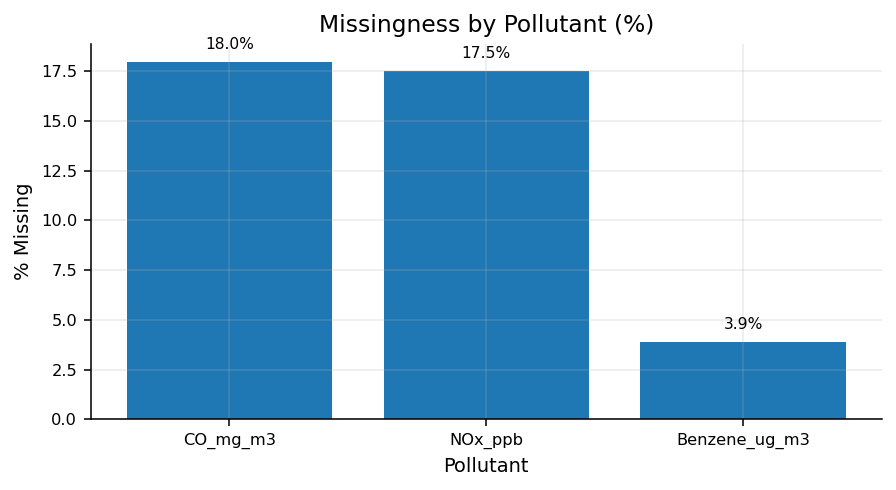

In [16]:
# % of missing per pollutant
miss_pct = df_poll[pollutants].isna().mean().sort_values(ascending=False) * 100
fig, ax = plt.subplots(figsize=(6.5, 3.6))
ax.bar(miss_pct.index, miss_pct.values)
ax.set_title("Missingness by Pollutant (%)")
ax.set_ylabel("% Missing")
ax.set_xlabel("Pollutant")
for i, v in enumerate(miss_pct.values):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha="center", va="bottom", fontsize=8)
show_fig(fig, "missingness_pollutants.png")

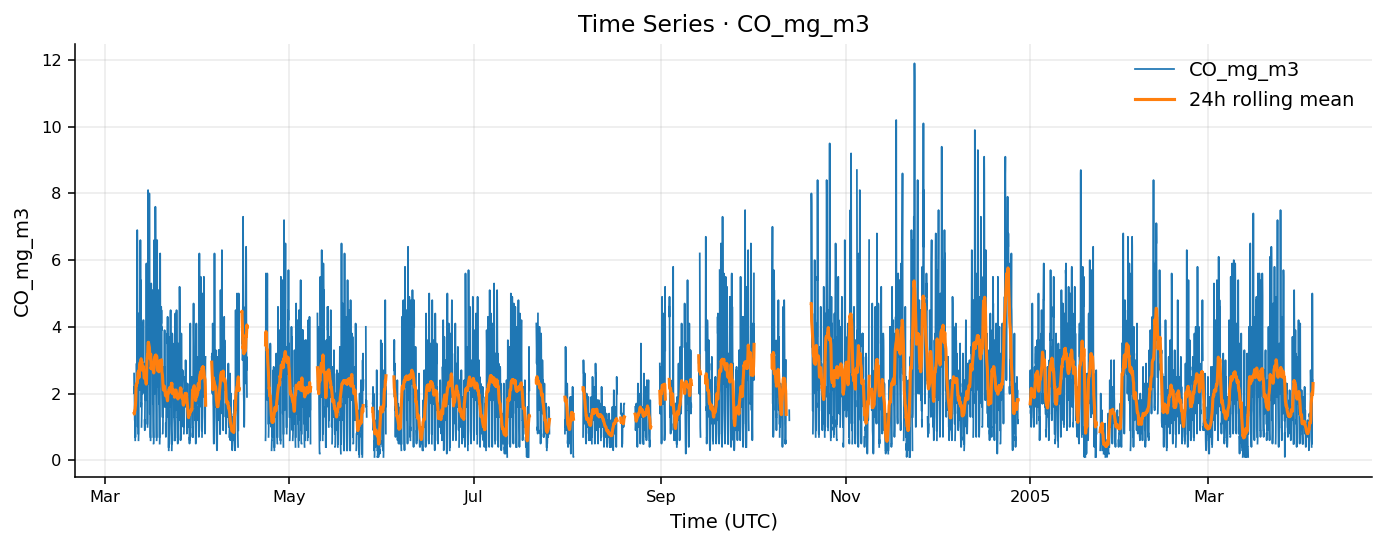

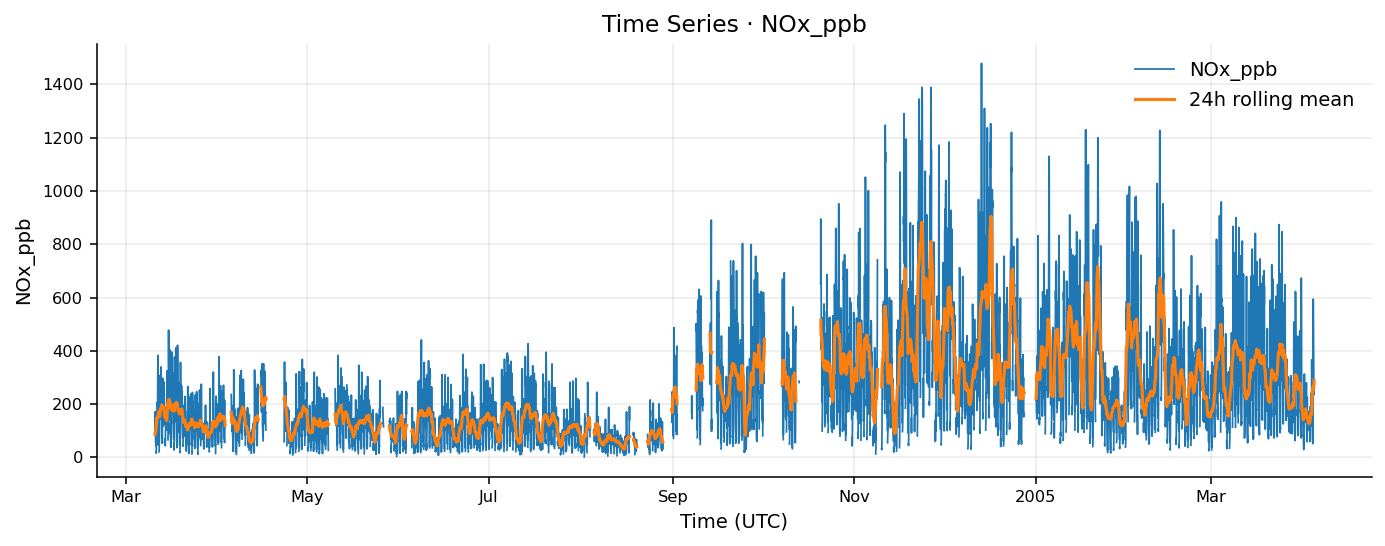

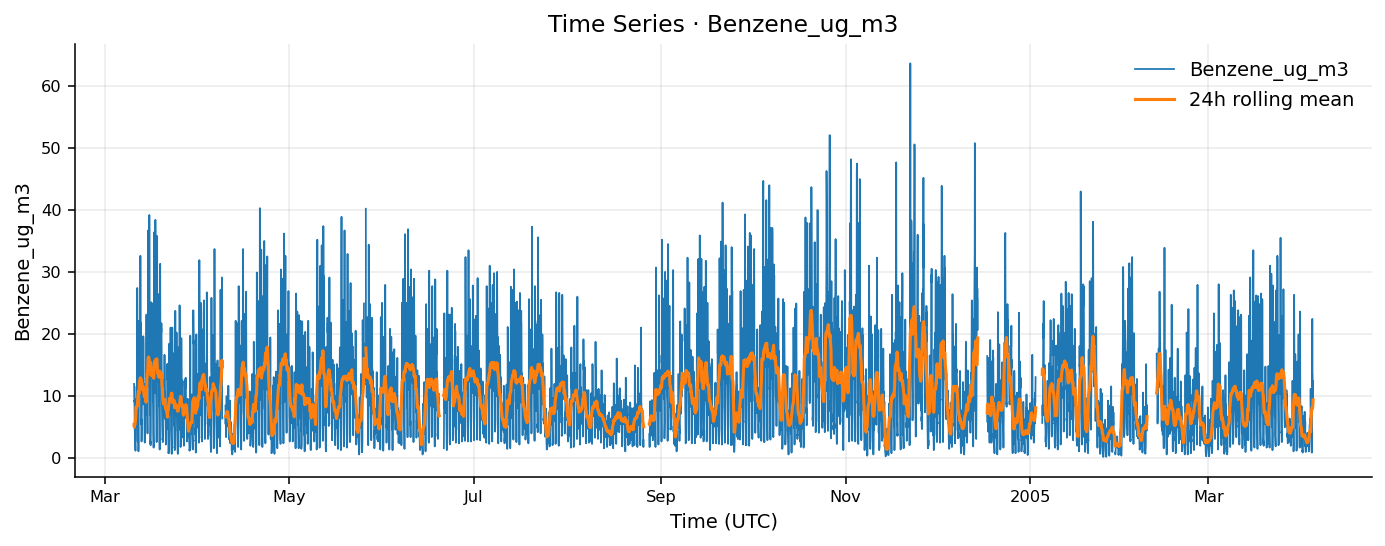

In [17]:
# Time-series with 24h rolling mean
for col in pollutants:
    ser = df_poll[col].astype(float)
    roll = ser.rolling(window=24, min_periods=12, center=True).mean()

    fig, ax = plt.subplots()
    ax.plot(ser.index, ser.values, lw=0.9, label=col)
    ax.plot(roll.index, roll.values, lw=1.6, label="24h rolling mean")
    _format_time_axis(ax)
    ax.set_title(f"Time Series · {col}")
    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel(col)
    ax.legend()
    show_fig(fig, f"time_series_{col}.png")

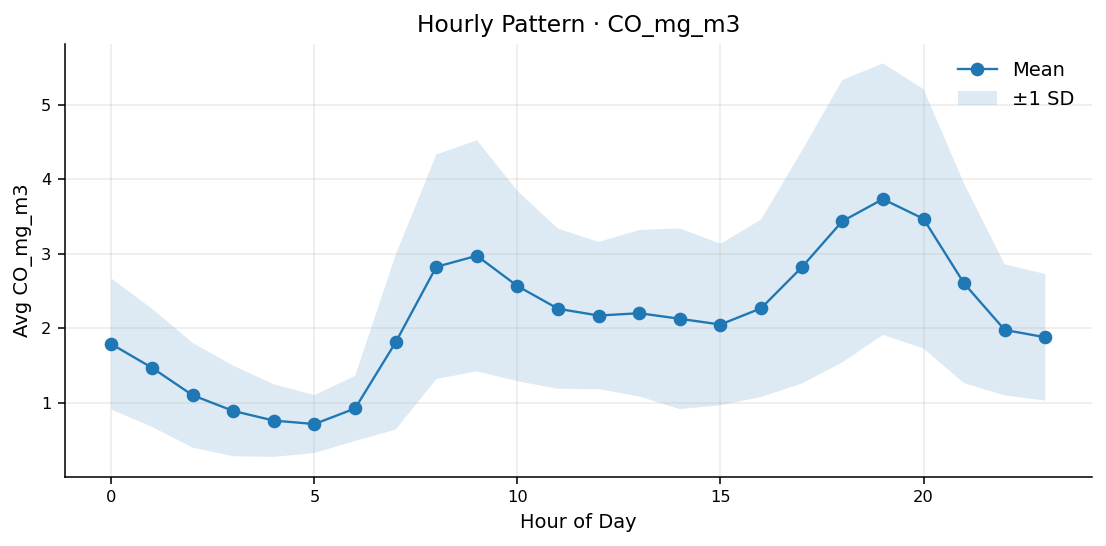

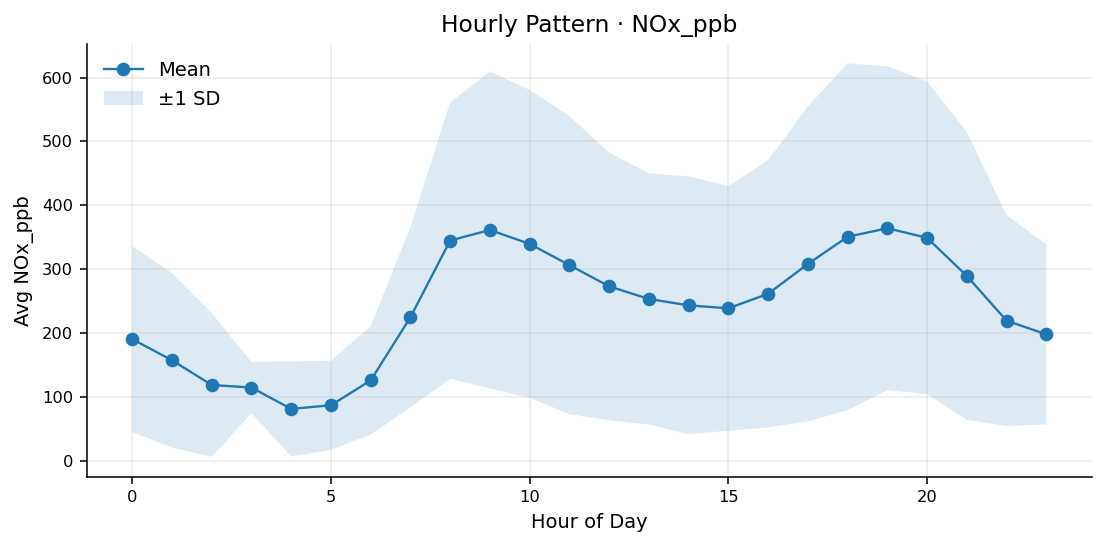

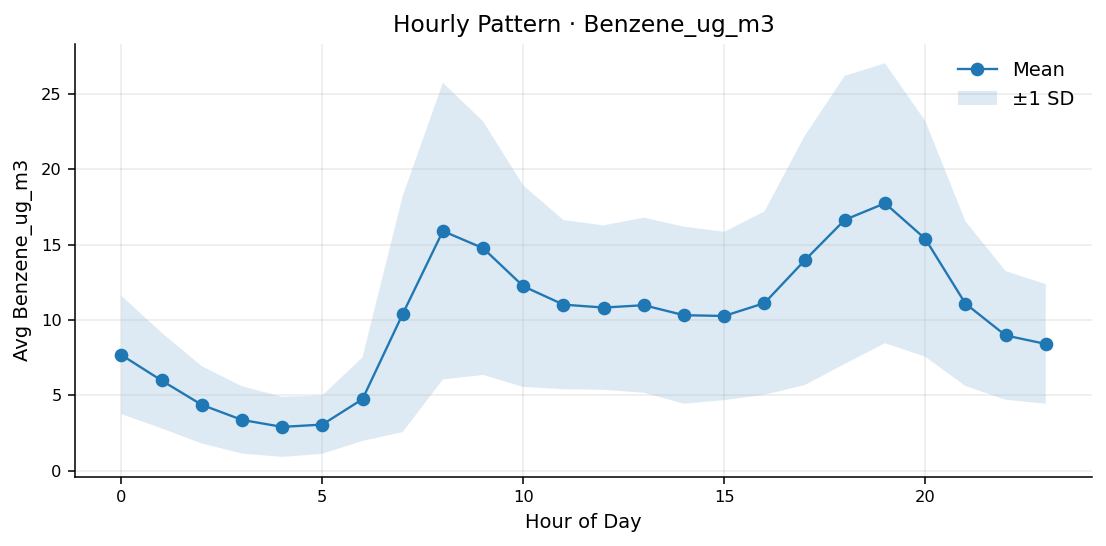

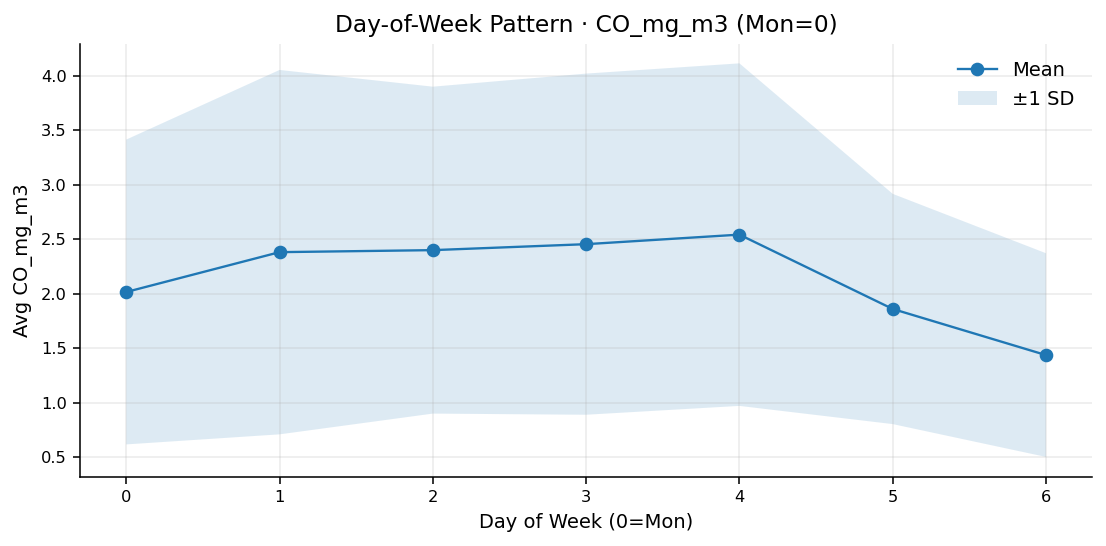

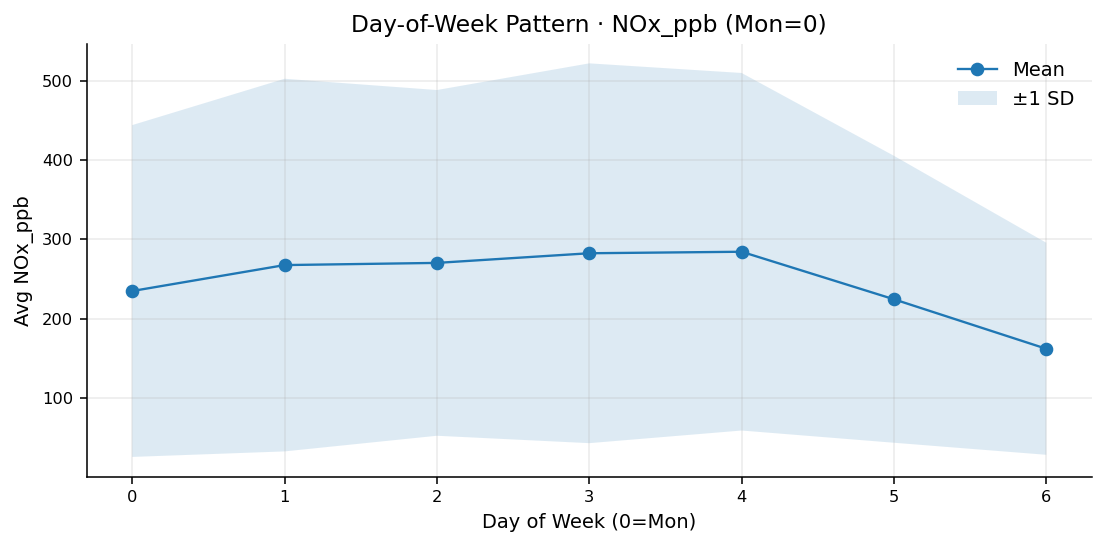

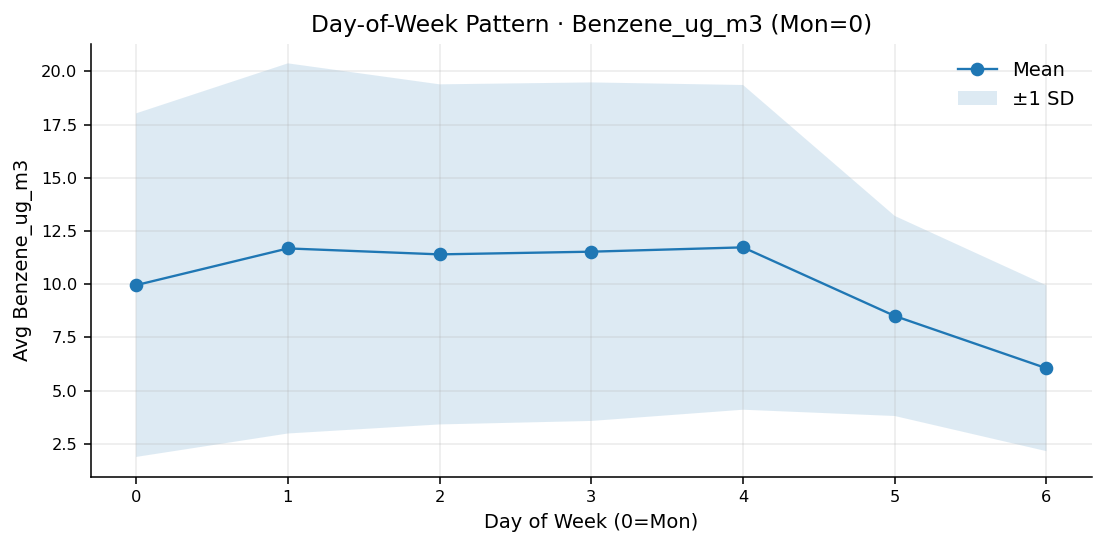

In [9]:
# Prepare stats
df_poll["hour"] = df_poll.index.hour
df_poll["dow"]  = df_poll.index.dayofweek

hourly_stats = df_poll.groupby("hour")[pollutants].agg(["mean", "std"])
dow_stats    = df_poll.groupby("dow")[pollutants].agg(["mean", "std"])

# Hourly
for col in pollutants:
    x = hourly_stats.index
    mu = hourly_stats[col]["mean"]
    sd = hourly_stats[col]["std"]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x, mu, marker="o", lw=1.2, label="Mean")
    ax.fill_between(x, mu - sd, mu + sd, alpha=0.15, label="±1 SD")
    ax.set_title(f"Hourly Pattern · {col}")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel(f"Avg {col}")
    ax.legend()
    show_fig(fig, f"hourly_pattern_{col}.png")

# Day-of-week
for col in pollutants:
    x = dow_stats.index
    mu = dow_stats[col]["mean"]
    sd = dow_stats[col]["std"]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x, mu, marker="o", lw=1.2, label="Mean")
    ax.fill_between(x, mu - sd, mu + sd, alpha=0.15, label="±1 SD")
    ax.set_title(f"Day-of-Week Pattern · {col} (Mon=0)")
    ax.set_xlabel("Day of Week (0=Mon)")
    ax.set_ylabel(f"Avg {col}")
    ax.legend()
    show_fig(fig, f"dow_pattern_{col}.png")

,CO_mg_m3,NOx_ppb,Benzene_ug_m3
CO_mg_m3,1.000000,0.795028,0.931078
NOx_ppb,0.795028,1.000000,0.718839
Benzene_ug_m3,0.931078,0.718839,1.000000


,CO_mg_m3,NOx_ppb,Benzene_ug_m3
CO_mg_m3,0.0,0.0,0.0
NOx_ppb,0.0,0.0,0.0
Benzene_ug_m3,0.0,0.0,0.0


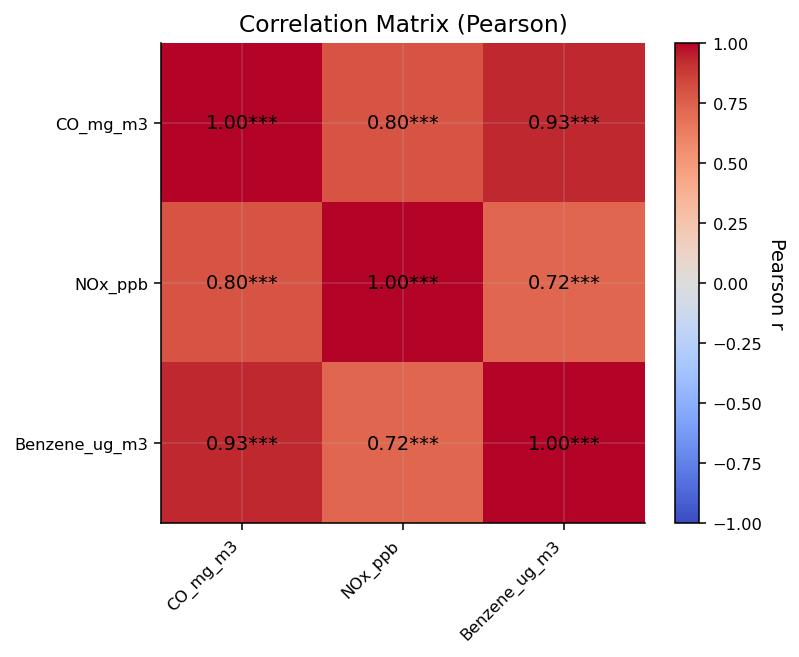

In [22]:
def corr_with_pvalues(df_in: pd.DataFrame):
    X = df_in.apply(pd.to_numeric, errors="coerce").copy()
    # drop columns that are entirely NaN
    X = X.dropna(axis=1, how="all")
    cols = X.columns

    corr = X.corr()
    pvals = pd.DataFrame(np.nan, index=cols, columns=cols, dtype=float)

    # fill diagonal
    for c in cols:
        corr.loc[c, c] = 1.0
        pvals.loc[c, c] = 0.0

    # Compute only upper triangle, then mirror
    for i, a in enumerate(cols):
        for j in range(i + 1, len(cols)):
            b = cols[j]
            sub = X[[a, b]].dropna()
            if len(sub) > 2:
                r, p = pearsonr(sub[a].values, sub[b].values)
                corr.loc[a, b] = r
                corr.loc[b, a] = r
                pvals.loc[a, b] = p
                pvals.loc[b, a] = p
            else:
                corr.loc[a, b] = np.nan
                corr.loc[b, a] = np.nan
                pvals.loc[a, b] = np.nan
                pvals.loc[b, a] = np.nan

    return corr, pvals

corr_mat, pvals = corr_with_pvalues(df_poll[pollutants])

display(corr_mat)
display(pvals)

corr_mat.to_csv("/mnt/data/correlation_matrix.csv")
pvals.to_csv("/mnt/data/correlation_pvalues.csv")

# Heatmap
fig, ax = plt.subplots(figsize=(5.8, 4.8))
im = ax.imshow(corr_mat.values, vmin=-1, vmax=1, cmap="coolwarm", aspect="auto")
ax.set_xticks(range(len(pollutants)))
ax.set_xticklabels(pollutants, rotation=45, ha="right")
ax.set_yticks(range(len(pollutants)))
ax.set_yticklabels(pollutants)
ax.set_title("Correlation Matrix (Pearson)")

def _stars(p):
    if np.isnan(p): return ""
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return ""

for i in range(len(pollutants)):
    for j in range(len(pollutants)):
        r = corr_mat.values[i, j]
        p = pvals.values[i, j] if not np.isnan(pvals.values[i, j]) else np.nan
        ax.text(j, i, f"{r:.2f}{_stars(p)}", ha="center", va="center")

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Pearson r", rotation=270, labelpad=12)
show_fig(fig, "correlation_matrix.png")

## 3. Advanced Analytics

<Figure size 1120x560 with 0 Axes>

<Figure size 1120x560 with 0 Axes>

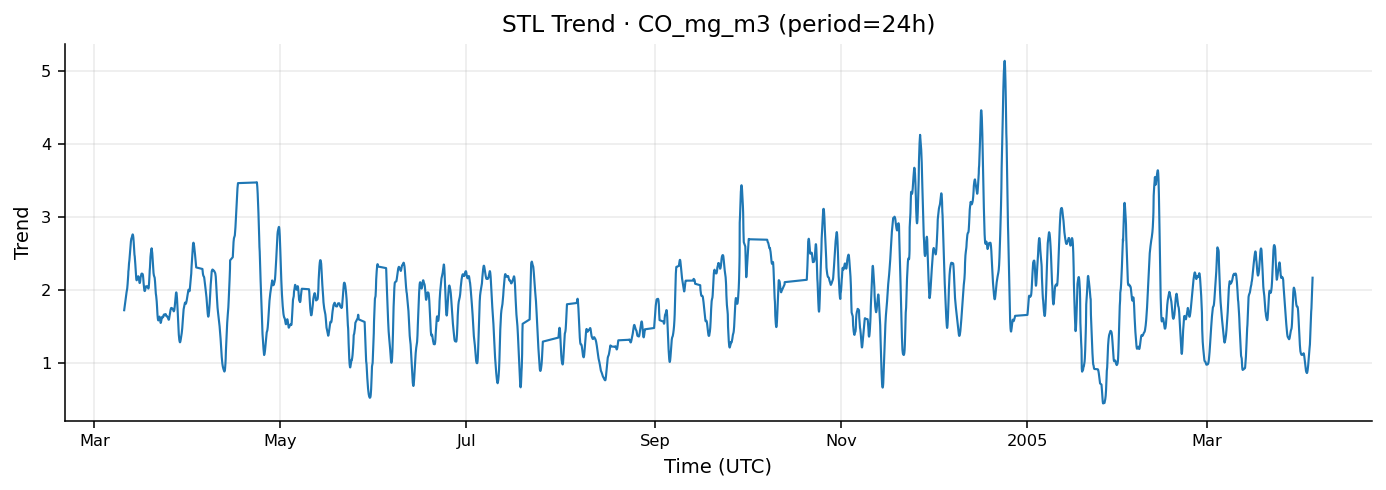

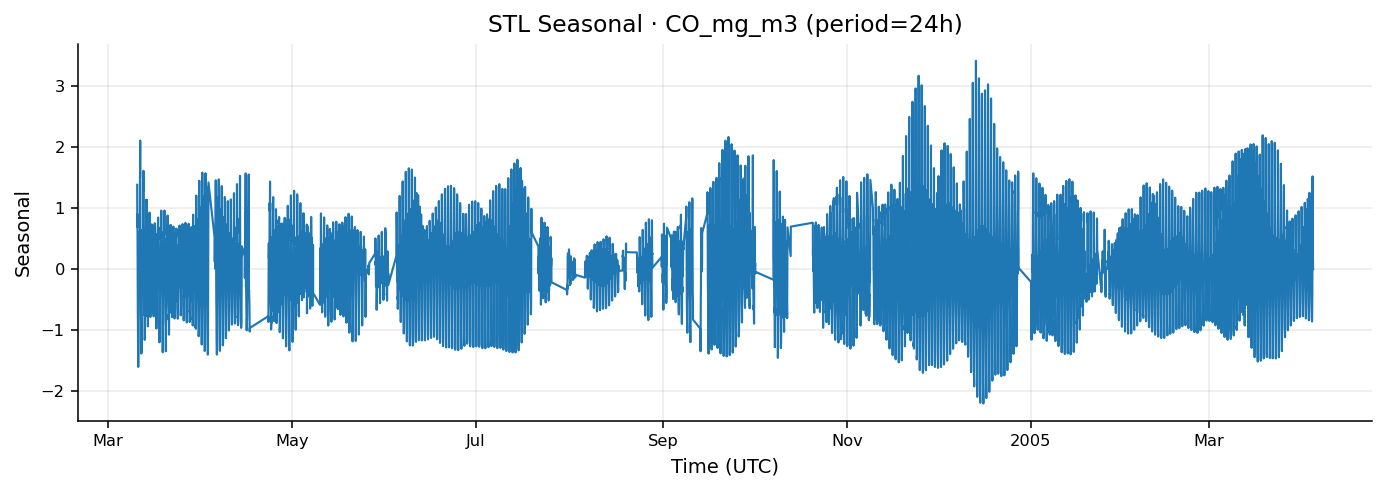

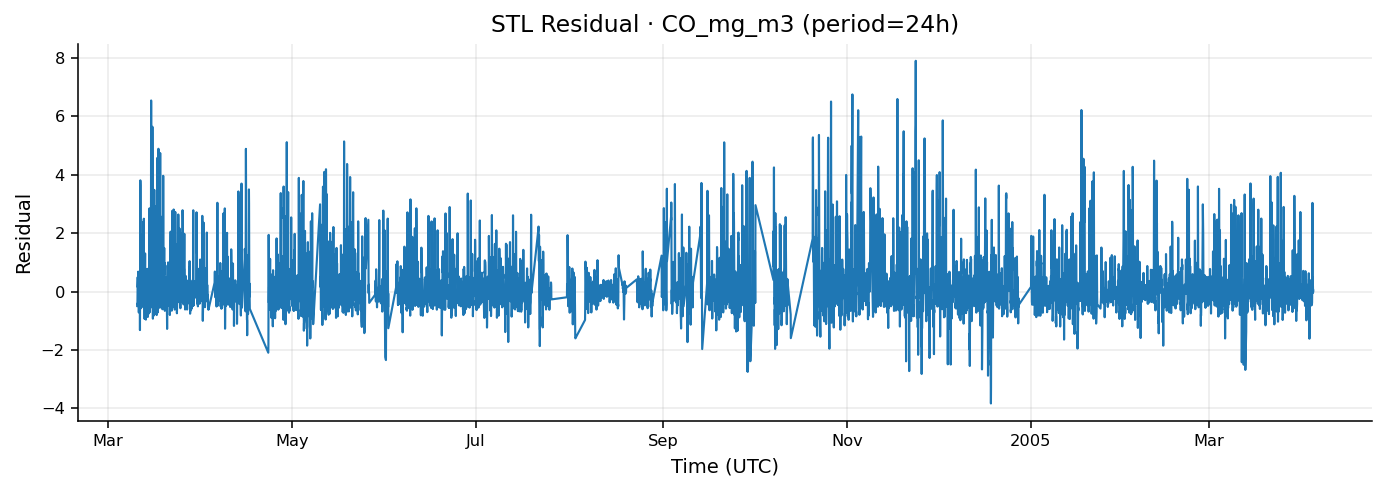

<Figure size 1120x560 with 0 Axes>

<Figure size 1120x560 with 0 Axes>

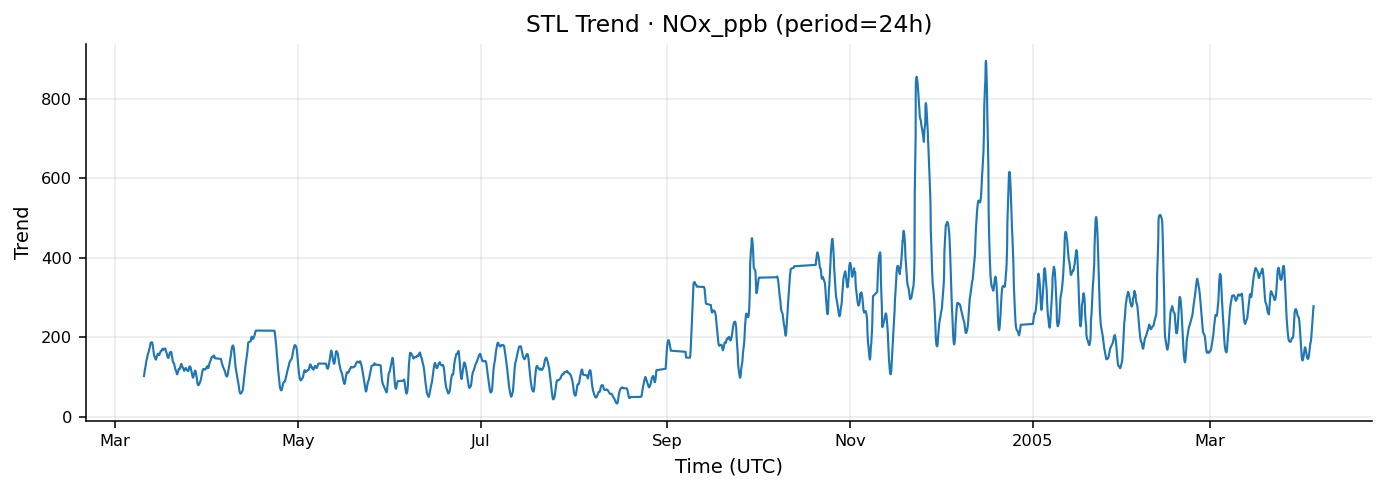

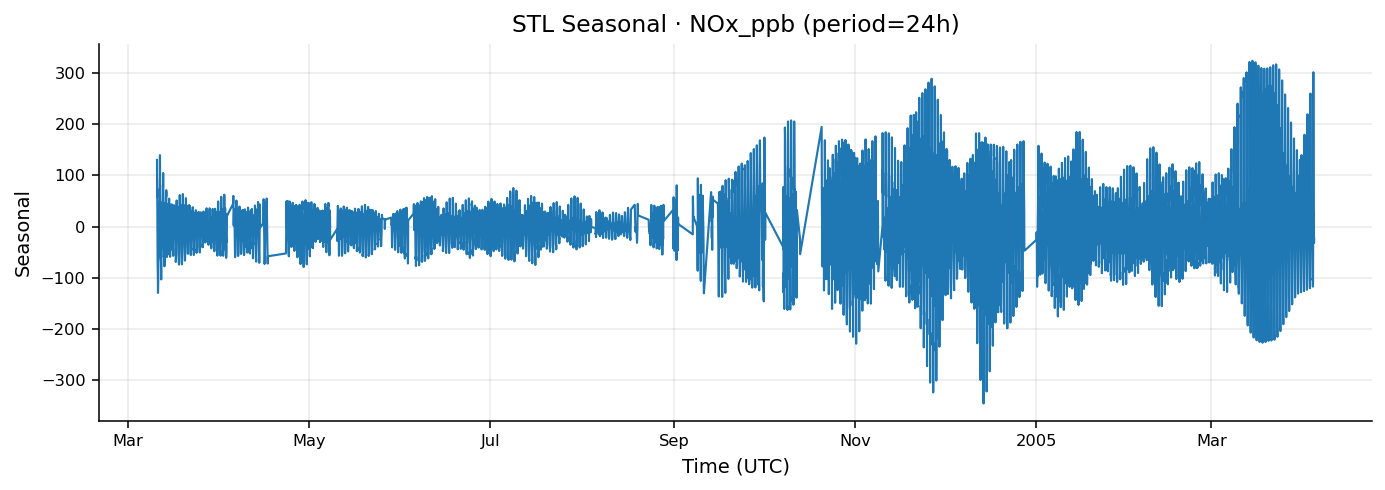

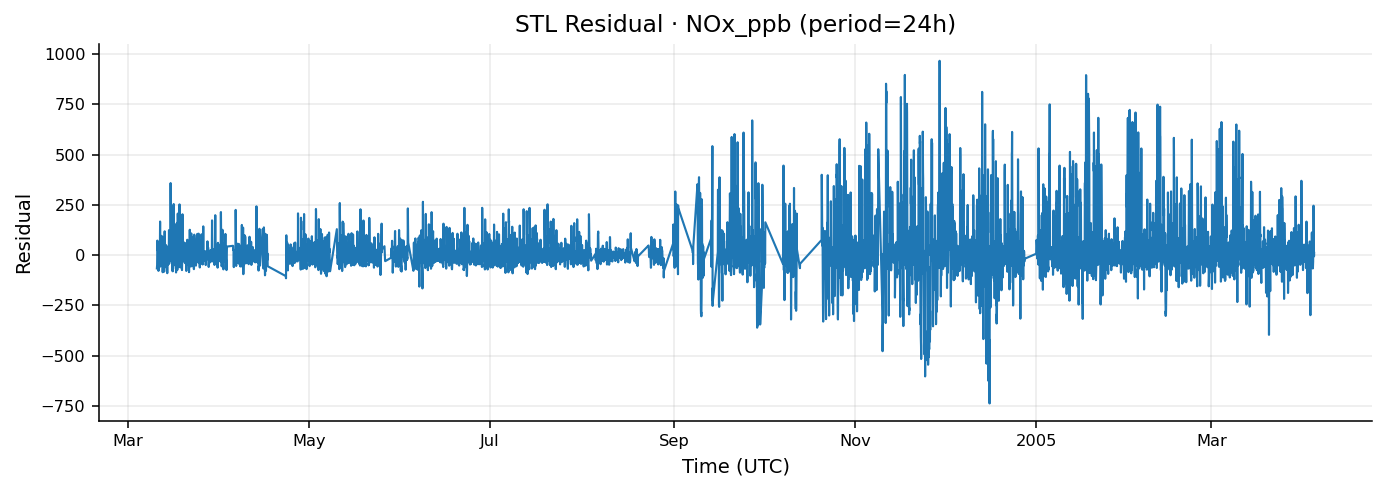

<Figure size 1120x560 with 0 Axes>

<Figure size 1120x560 with 0 Axes>

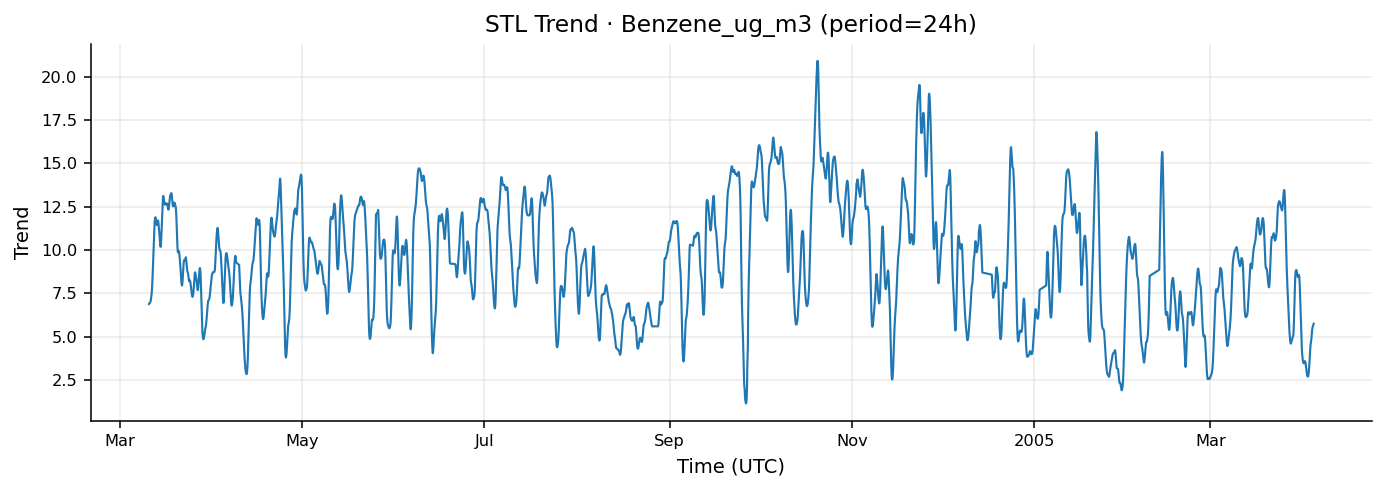

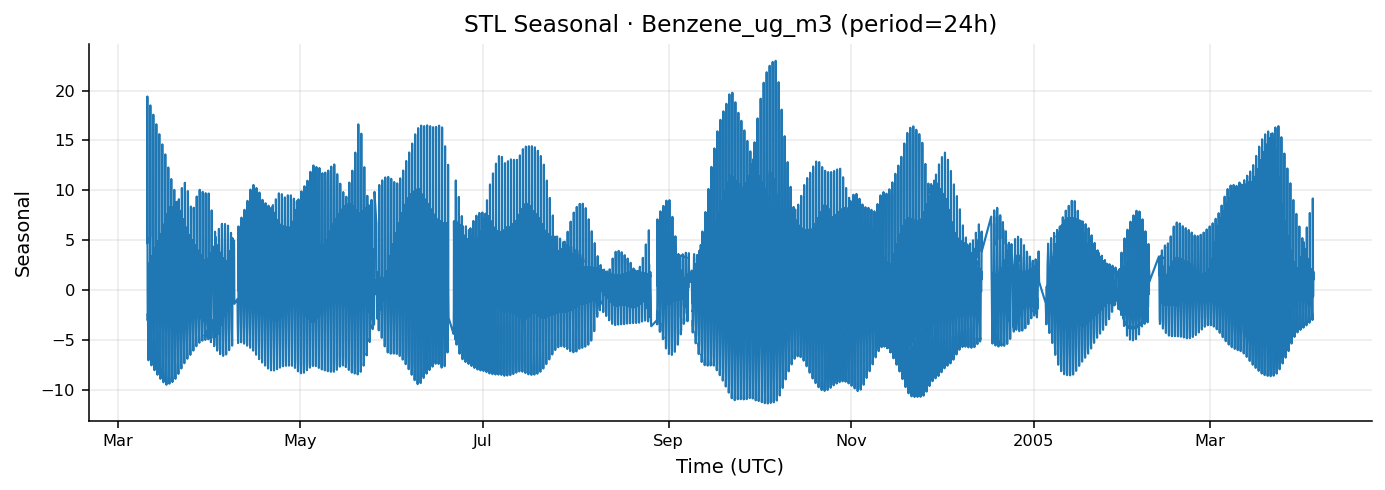

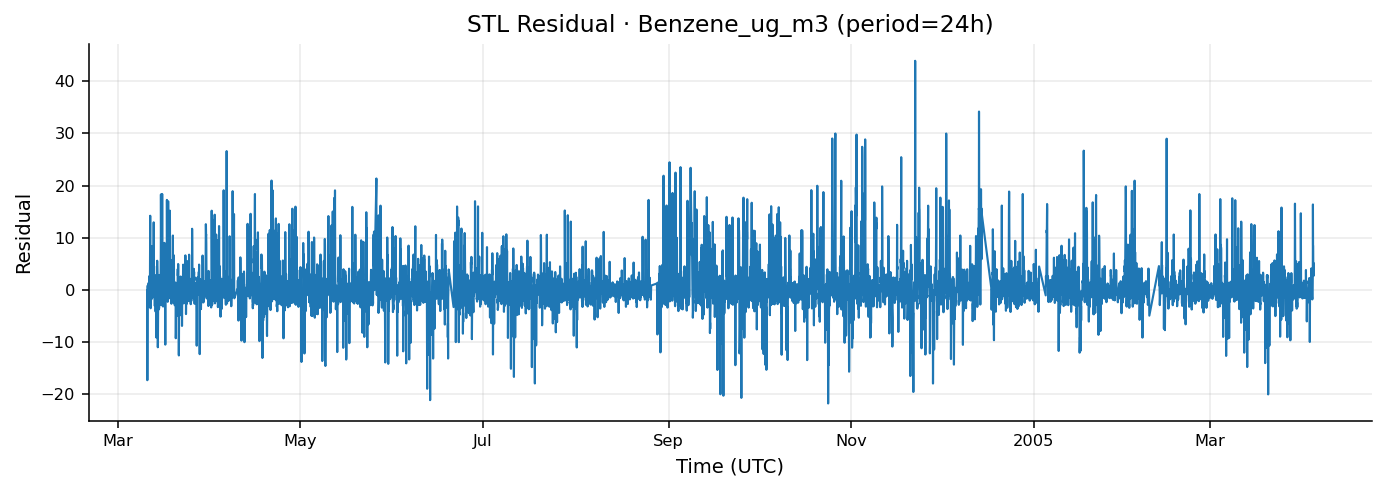

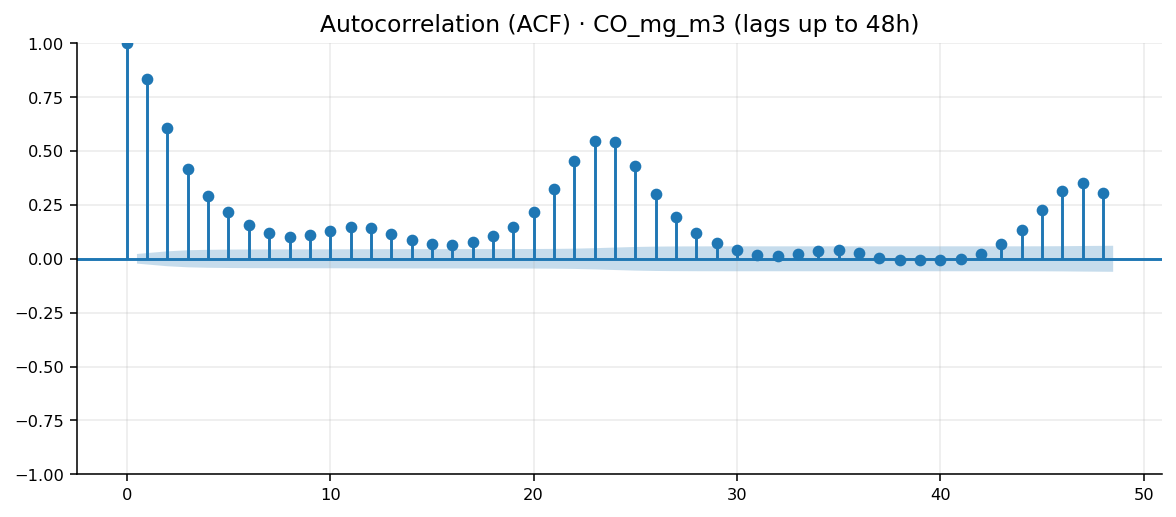

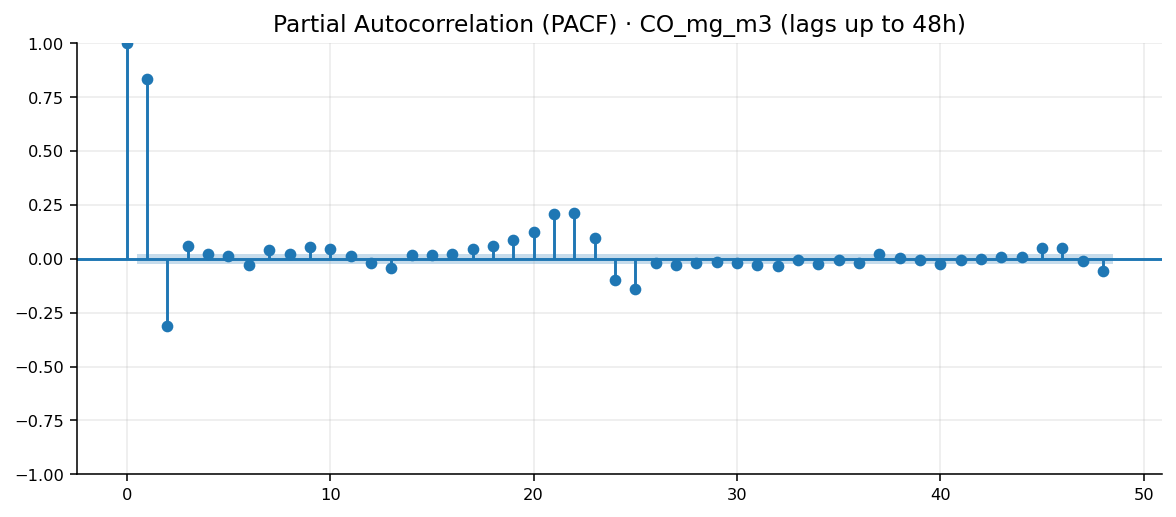

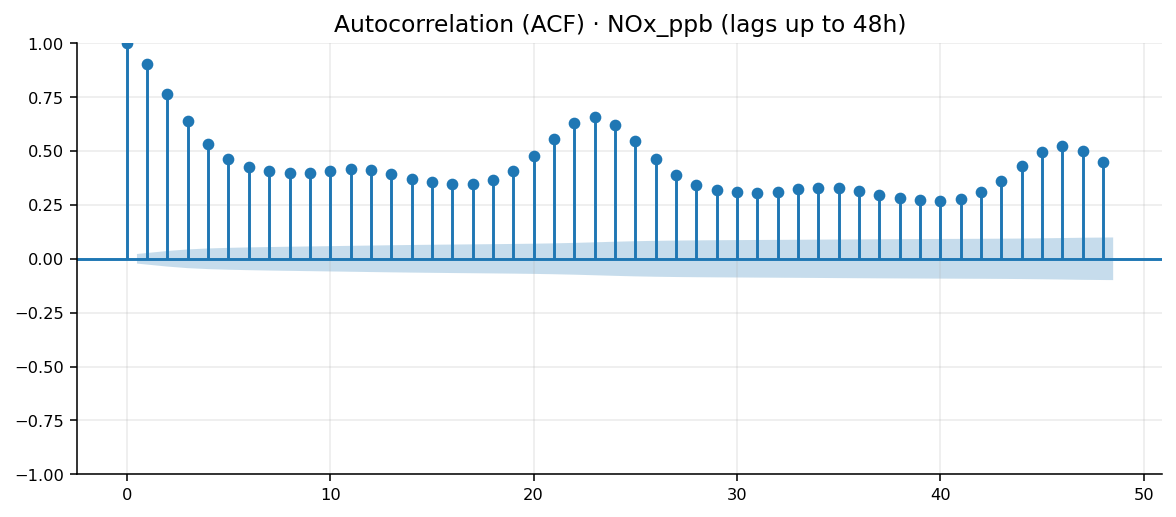

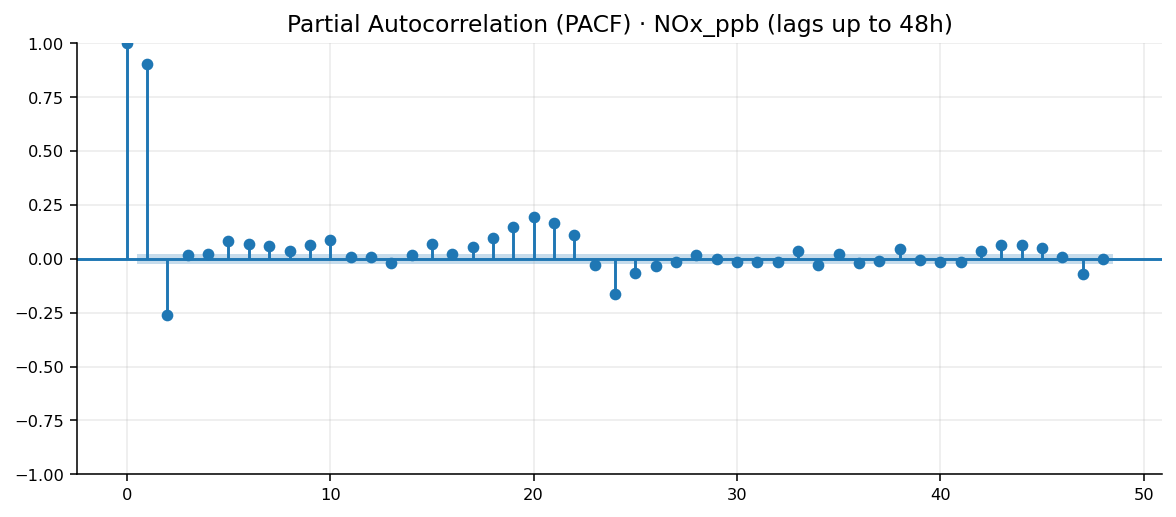

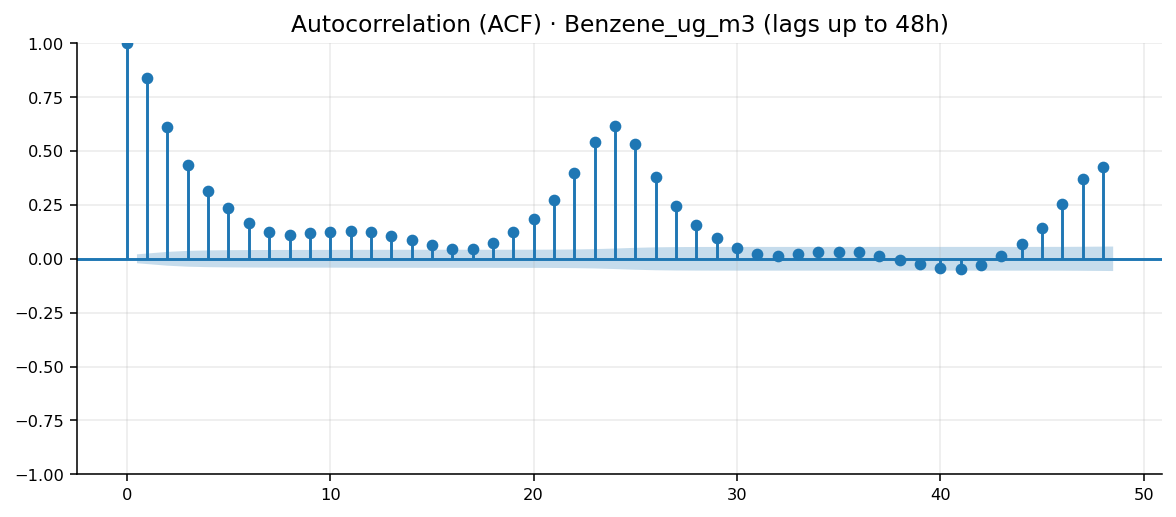

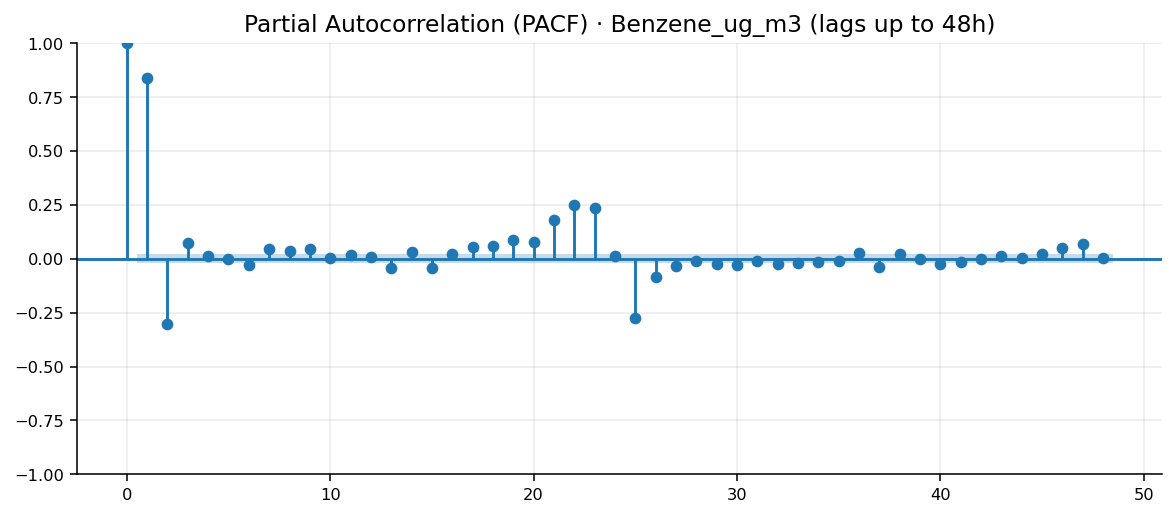

In [13]:
for col in pollutants:
    ser = df_poll[col].astype(float).dropna()

    # ACF
    if plot_acf is not None:
        fig = plt.figure(figsize=(8, 4))
        plot_acf(ser, lags=48)
        plt.title(f"Autocorrelation (ACF) · {col} (lags up to 48h)")
        show_fig(fig, f"acf_{col}.png")

    # PACF
    if plot_pacf is not None:
        fig = plt.figure(figsize=(8, 4))
        plot_pacf(ser, lags=48, method="ywm")
        plt.title(f"Partial Autocorrelation (PACF) · {col} (lags up to 48h)")
        show_fig(fig, f"pacf_{col}.png")

    # STL
    seasonal_period = 24
    if STL is not None:
        try:
            stl = STL(ser, period=seasonal_period, robust=True, seasonal=13)
            res = stl.fit()
            for name, series in [("Trend", res.trend), ("Seasonal", res.seasonal), ("Residual", res.resid)]:
                fig, ax = plt.subplots(figsize=(10, 3.6))
                ax.plot(series.index, series.values, lw=1.1)
                _format_time_axis(ax)
                ax.set_title(f"STL {name} · {col} (period={seasonal_period}h)")
                ax.set_xlabel("Time (UTC)")
                ax.set_ylabel(name)
                show_fig(fig, f"stl_{name.lower()}_{col}.png")
        except Exception:
            pass

In [27]:
def build_summary(df_poll, pollutants, corr_mat, pvals, anomaly_dir="/mnt/data/anomaly_tables"):
    df = df_poll.copy()

    # Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        try:
            df.index = pd.to_datetime(df.index, errors="coerce", utc=True)
        except Exception:
            pass

    # Derive hour/dow
    if isinstance(df.index, pd.DatetimeIndex):
        if "hour" not in df.columns:
            df["hour"] = df.index.hour
        if "dow" not in df.columns:
            df["dow"] = df.index.dayofweek

    cols = [c for c in pollutants if c in df.columns]
    if not cols:
        display(Markdown("**Warning:** None of the requested pollutant columns are present."))
        return

    points = []

    # Data coverage
    start, end = df.index.min(), df.index.max()
    n = len(df)
    if pd.notna(start) and pd.notna(end):
        points.append(f"**Data coverage:** {start:%Y-%m-%d %H:%M} → {end:%Y-%m-%d %H:%M} ({n:,} hourly records)")
    else:
        points.append(f"**Data coverage:** {n:,} rows (timestamp parsing incomplete)")

    # Missingness (%)
    miss = (df[cols].isna().mean() * 100).round(1).to_dict()
    miss_str = ", ".join([f"{k}: {v}%" for k, v in miss.items()])
    points.append(f"**Missingness:** {miss_str}")

    # Correlations with significance
    if corr_mat is not None and pvals is not None:
        for i, a in enumerate(cols):
            for j, b in enumerate(cols):
                if j > i and (a in corr_mat.index and b in corr_mat.columns):
                    r = corr_mat.loc[a, b]
                    p = pvals.loc[a, b]
                    sig = "significant" if p < 0.05 else "not significant"
                    points.append(f"**{a} vs {b}:** r = {r:.2f}, p = {p:.2e} ({sig})")

    # Hourly / DOW summaries
    if "hour" in df.columns:
        hourly_means = df.groupby("hour")[cols].mean()
        for col in cols:
            try:
                points.append(f"**{col}:** peaks around {int(hourly_means[col].idxmax())}h, "
                              f"trough around {int(hourly_means[col].idxmin())}h")
            except Exception:
                pass

    if "dow" in df.columns:
        dow_means = df.groupby("dow")[cols].mean()
        for col in cols:
            try:
                points.append(f"**{col}:** highest on DOW={int(dow_means[col].idxmax())}, "
                              f"lowest on DOW={int(dow_means[col].idxmin())} (Mon=0)")
            except Exception:
                pass

    # Anomalies
    anomaly_dir = Path(anomaly_dir)
    for col in cols:
        csv_path = anomaly_dir / f"anomalies_{col}.csv"
        try:
            cnt = len(pd.read_csv(csv_path, index_col=0))
        except Exception:
            cnt = 0
        points.append(f"**{col}:** detected {cnt} anomalies")

    display(Markdown("## Executive Summary — Key Findings"))
    for p in points:
        display(Markdown(f"- {p}"))

build_summary(df_poll, pollutants, corr_mat, pvals)

## Executive Summary — Key Findings

- **Data coverage:** 2004-03-10 18:00 → 2005-04-04 14:00 (9,357 hourly records)

- **Missingness:** CO_mg_m3: 18.0%, NOx_ppb: 17.5%, Benzene_ug_m3: 3.9%

- **CO_mg_m3 vs NOx_ppb:** r = 0.80, p = 0.00e+00 (significant)

- **CO_mg_m3 vs Benzene_ug_m3:** r = 0.93, p = 0.00e+00 (significant)

- **NOx_ppb vs Benzene_ug_m3:** r = 0.72, p = 0.00e+00 (significant)

- **CO_mg_m3:** peaks around 19h, trough around 5h

- **NOx_ppb:** peaks around 19h, trough around 4h

- **Benzene_ug_m3:** peaks around 19h, trough around 4h

- **CO_mg_m3:** highest on DOW=4, lowest on DOW=6 (Mon=0)

- **NOx_ppb:** highest on DOW=4, lowest on DOW=6 (Mon=0)

- **Benzene_ug_m3:** highest on DOW=4, lowest on DOW=6 (Mon=0)

- **CO_mg_m3:** detected 0 anomalies

- **NOx_ppb:** detected 0 anomalies

- **Benzene_ug_m3:** detected 0 anomalies